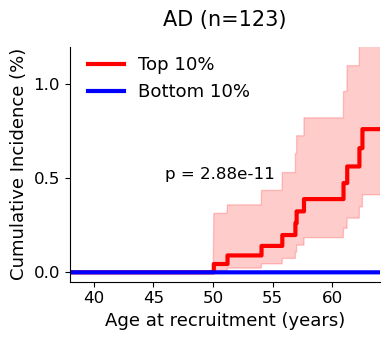

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np

# Load dataset
data = pd.read_csv('../../data/4.AD/AR+ST+ET+event+Age.csv')

# Calculate thresholds for top 10% and bottom 10% aging rates
bottom_threshold = data['aging_rate'].quantile(0.90)
top_threshold = data['aging_rate'].quantile(0.10)

# Create categorical groups based on aging rate percentiles
data['aging_rate_group'] = pd.cut(
    data['aging_rate'],
    bins=[-np.inf, top_threshold, bottom_threshold, np.inf],
    labels=['Bottom 10%', 'Middle', 'Top 10%']
)

# Filter to keep only extreme groups
data = data[data['aging_rate_group'].isin(['Top 10%', 'Bottom 10%'])]

# Convert date columns to datetime format
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Calculate survival time in days and years
data['survival_time_days'] = (data['end_time'] - data['start_time']).dt.days
data['survival_time_years'] = data['survival_time_days'] / 365.25

# Calculate age at event occurrence
data['age_at_event'] = data['Age'] + data['survival_time_years']

# Ensure numeric data types and remove any missing values
data['age_at_event'] = pd.to_numeric(data['age_at_event'], errors='coerce')
data['event'] = pd.to_numeric(data['event'], errors='coerce')
data = data.dropna(subset=['age_at_event', 'event'])

# Split data into comparison groups
top_group = data[data['aging_rate_group'] == 'Top 10%']
bottom_group = data[data['aging_rate_group'] == 'Bottom 10%']

# Perform log-rank test to compare survival curves
results = logrank_test(
    top_group['age_at_event'], 
    bottom_group['age_at_event'], 
    event_observed_A=top_group['event'], 
    event_observed_B=bottom_group['event']
)
p_value = results.p_value

# Initialize figure with specified dimensions
plt.figure(figsize=(4, 3.5))
kmf = KaplanMeierFitter()

# Color scheme for visualization
colors = {'Top 10%': 'red', 'Bottom 10%': 'blue'}

# Plot survival curves for each group
for group in ['Top 10%', 'Bottom 10%']:
    grouped_data = data[data['aging_rate_group'] == group]
    T = grouped_data['age_at_event']
    E = grouped_data['event']

    # Skip if no data available for group
    if T.empty or E.empty:
        continue

    # Fit Kaplan-Meier model
    kmf.fit(T, E, label=group)

    # Calculate cumulative incidence
    cumulative_incidence = 1 - kmf.survival_function_

    # Plot main survival curve
    plt.step(
        cumulative_incidence.index,
        cumulative_incidence.values.flatten() * 100,
        where='post',
        lw=3,
        color=colors[group],
        label=f'{group}'
    )

    # Add 95% confidence intervals
    ci = 1 - kmf.confidence_interval_
    plt.fill_between(
        ci.index,
        ci.iloc[:, 0] * 100,
        ci.iloc[:, 1] * 100,
        color=colors[group],
        alpha=0.2
    )

# Add title and axis labels
plt.title('AD (n=123)', fontsize=15, pad=15)
plt.xlabel('Age at recruitment (years)', fontsize=13)
plt.ylabel('Cumulative Incidence (%)', fontsize=13)

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Configure legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.32, 0.7),
    ncol=1,
    columnspacing=2,
    frameon=False,
    fontsize=13
)

# Adjust tick parameters
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

# Set axis limits and ticks
plt.xlim(38, 64)
plt.yticks(np.arange(0, 65, 10))
plt.ylim(-0.05, 1.2)
plt.yticks(np.arange(0, 1.2, 0.5))

# Add p-value annotation
plt.text(
    46, 0.52, f'p = {p_value:.2e}',
    fontsize=12,
    ha='left', va='center'
)

# Final layout adjustment and display
plt.tight_layout()
plt.show()